In [14]:
import numpy
import pandas
import timeit
from collections import Counter

In [2]:
samples = ['BLCA', 'BRCA', 'CESC', 'CHOL',
           'COAD', 'ESCA', 'GBM', 'HNSC',
           'KICH', 'KIRC', 'LUAD', 'LUSC', 
           'PAAD', 'PCPG', 'PRAD', 'READ',
           'SARC', 'STAD', 'THCA', 'THYM', 'UCEC']

In [3]:
len(samples)

21

In [80]:
def assign_prevailing_forms(dataset: pandas.DataFrame) -> pandas.DataFrame:
    ''' Given initial TCGA dataset, iterate through unique genes and:
        1. If gene has a single isoform in dataset, simply assign it to all samples
        2. If gene has multiple isoforms, find isoforms with maximum abundance for
           each sample using .idxmax() method and assign the result to samples, 
           collapsing data to one row per gene.
    '''
    #Construct dataframe to return from initial dataset, drop unnecessary columns
    result = (dataset.copy()
              .drop(['UniProt', 'canonical', 'chr', 'ucsc', 'Avg'], axis=1)
              .drop_duplicates('Gene')
              .astype(str)
              .set_index('Gene')
              .drop(['-'], axis=0))
    
    #Iterate over genes
    for i, g in enumerate(result.index):
        subset_g = dataset[dataset['Gene'] == g]
        
        #If gene has only one isoform, propagate it to all samples
        if len(subset_g) == 1:
            result.iloc[i] = subset_g.iat[0, 0]
        
        #Otherwise, find isoforms with maximum abundance for each sample
        else:
            # Setting UniProt ID as index in view to use .idxmax() method
            subset_g = subset_g.set_index('UniProt', drop=True).iloc[:,5:]
            result.iloc[i] = subset_g.idxmax()
            
    return result

In [46]:
start = timeit.default_timer()
for i, s in enumerate(samples):
    new = timeit.default_timer()
    
    #Handle 'cancer' dataset
    sc_data = pandas.read_csv(f'../data/tcga_initial/{s}_canc.tsv', sep='\t')
    sc_prev = assign_prevailing_forms(sc_data)
    sc_prev.to_csv(f'../data/tcga_prevailing/{s}_canc.csv', index=True)
    
    #Handle 'norm' dataset
    sn_data = pandas.read_csv(f'../data/tcga_initial/{s}_norm.tsv', sep='\t')
    sn_prev = assign_prevailing_forms(sn_data)
    sn_prev.to_csv(f'../data/tcga_prevailing/{s}_norm.csv', index=True)
    
    elapsed_one = timeit.default_timer() - new
    elapsed_total = timeit.default_timer() - start
    
    msg = f'Done {i+1} out of {len(samples)} samples, '\
          f'last took {elapsed_one:.2f} s, total {elapsed_total:.2f} s'
    
    print(msg, end='\r')

In [47]:
BRCA_canc_prev = pandas.read_csv(f'../data/tcga_prevailing/BRCA_canc.csv', index_col=0)
COAD_norm_prev = pandas.read_csv(f'../data/tcga_prevailing/COAD_norm.csv', index_col=0)
READ_canc_prev = pandas.read_csv(f'../data/tcga_prevailing/READ_canc.csv', index_col=0)

assert BRCA_canc_prev.loc['TRBC2', 'TCGA-3C-AALJ-01A-31R-A41B-07'] == 'A0A5B9'
assert BRCA_canc_prev.loc['KANSL1L', 'TCGA-3C-AALJ-01A-31R-A41B-07'] == 'A0AUZ9'
assert BRCA_canc_prev.loc['KANSL1L', 'TCGA-V7-A7HQ-01A-11R-A33J-07'] == 'A0AUZ9-3'
assert BRCA_canc_prev.loc['CAMTA1', 'TCGA-UU-A93S-01A-21R-A41B-07'] == 'Q9Y6Y1'

assert COAD_norm_prev.loc['DHRS12', 'TCGA-A6-2675-11A-01R-1723-07'] == 'A0PJE2'
assert COAD_norm_prev.loc['FUOM', 'TCGA-A6-2671-11A-01R-A32Z-07'] == 'A2VDF0-2'
assert COAD_norm_prev.loc['BTBD11', 'TCGA-A6-2675-11A-01R-1723-07'] == 'A6QL63'
assert COAD_norm_prev.loc['BTBD11', 'TCGA-A6-2678-11A-01R-A32Z-07'] == 'A6QL63-4'

assert READ_canc_prev.loc['MED19', 'TCGA-AF-3911-01A-01R-1736-07'] == 'A0JLT2'
assert READ_canc_prev.loc['GFRA2', 'TCGA-F5-6812-01A-11R-1830-07'] == 'O00451-2'
assert READ_canc_prev.loc['TIGD4', 'TCGA-F5-6864-01A-11R-1928-07'] == 'Q8IY51'
assert READ_canc_prev.loc['ATAD5', 'TCGA-AF-3911-01A-01R-1736-07'] == 'Q96QE3'

In [52]:
def extract_dominant_form(isoform_list: pandas.Series):
    ''' Find frequencies of isoforms for a given gene
        Return a dominant isoform if its frequency >= 80%
        Else return NaN
    '''
    isoform_counts = isoform_list.value_counts(normalize=True)
    if isoform_counts[0] >= 0.75:
        return isoform_counts.index[0]
    else:
        return numpy.nan

In [53]:
#Create a list of all genes from all datasets
for s in samples:
    genes_canc = set(pandas.read_csv(f'../data/tcga_prevailing/{s}_canc.csv', usecols=[0])['Gene'].to_list())
    genes_norm = set(pandas.read_csv(f'../data/tcga_prevailing/{s}_norm.csv', usecols=[0])['Gene'].to_list())
    genes_all = genes_canc | genes_norm
    
genes_all = sorted(list(genes_all))

consensus_canc = pandas.DataFrame(index=genes_all, columns=samples)
consensus_norm = pandas.DataFrame(index=genes_all, columns=samples)

for i, s in enumerate(samples):
    sdata_prev = pandas.read_csv(f'../data/tcga_prevailing/{s}_canc.csv', index_col=0)
    consensus_canc[f'{s}'] = sdata_prev.apply(extract_dominant_form, axis=1)
    print(f'Done {i+1} of {len(samples)} cancer datasets', end='\r')
    
for i, s in enumerate(samples):
    sdata_prev = pandas.read_csv(f'../data/tcga_prevailing/{s}_norm.csv', index_col=0)
    consensus_norm[f'{s}'] = sdata_prev.apply(extract_dominant_form, axis=1)
    print(f'Done {i+1} of {len(samples)} norm datasets', end='\r')

In [60]:
n_canc = [len(pandas.read_csv(f'../data/tcga_prevailing/{s}_canc.csv', index_col=0).columns) for s in samples]
n_norm = [len(pandas.read_csv(f'../data/tcga_prevailing/{s}_norm.csv',index_col=0).columns) for s in samples]

n_samples = pandas.DataFrame(index=samples, data={'Cancer': n_samples_canc, 'Norm': n_samples_norm})
n_samples.to_excel('../results/data_initial_len.xlsx')

In [35]:
consensus_canc

,BLCA,BRCA,CESC,CHOL,COAD,ESCA,GBM,HNSC,KICH,KIRC,...,LUSC,PAAD,PCPG,PRAD,READ,SARC,STAD,THCA,THYM,UCEC
A1BG,P04217,P04217,P04217,P04217,P04217,P04217,P04217,P04217,P04217,P04217,...,P04217,P04217,P04217,P04217,P04217,P04217,P04217,P04217,P04217,P04217
A2M,P01023,P01023,P01023,P01023,P01023,P01023,P01023,P01023,P01023,P01023,...,P01023,P01023,P01023,P01023,P01023,P01023,P01023,P01023,P01023,P01023
A2ML1,A8K2U0,A8K2U0,A8K2U0,NaN,NaN,A8K2U0,A8K2U0,A8K2U0,NaN,NaN,...,A8K2U0,A8K2U0,NaN,A8K2U0,NaN,NaN,A8K2U0,NaN,NaN,A8K2U0
A4GNT,Q9UNA3,Q9UNA3,Q9UNA3,Q9UNA3,Q9UNA3,Q9UNA3,Q9UNA3,Q9UNA3,Q9UNA3,Q9UNA3,...,Q9UNA3,Q9UNA3,Q9UNA3,Q9UNA3,Q9UNA3,Q9UNA3,Q9UNA3,Q9UNA3,Q9UNA3,Q9UNA3
AAAS,Q9NRG9,Q9NRG9,Q9NRG9,Q9NRG9,Q9NRG9,Q9NRG9,Q9NRG9,Q9NRG9,Q9NRG9,Q9NRG9,...,Q9NRG9,Q9NRG9,Q9NRG9,Q9NRG9,Q9NRG9,Q9NRG9,Q9NRG9,Q9NRG9,Q9NRG9,Q9NRG9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,NaN,NaN,NaN,Q6WRX3-2,Q6WRX3-2,NaN,Q6WRX3-2,NaN,Q6WRX3-2,NaN,...,NaN,Q6WRX3-2,Q6WRX3-2,Q6WRX3-2,NaN,NaN,NaN,NaN,Q6WRX3-2,NaN
ZYG11B,Q9C0D3-2,NaN,Q9C0D3-2,Q9C0D3-2,NaN,NaN,Q9C0D3-2,NaN,NaN,NaN,...,NaN,Q9C0D3-2,Q9C0D3-2,Q9C0D3-2,NaN,Q9C0D3-2,Q9C0D3,Q9C0D3-2,Q9C0D3-2,Q9C0D3-2
ZYX,Q15942,Q15942,Q15942,Q15942,Q15942,Q15942,Q15942,Q15942,Q15942,Q15942,...,Q15942,Q15942,Q15942,Q15942,Q15942,Q15942,Q15942,Q15942,Q15942,Q15942
ZZEF1,O43149,O43149,O43149,O43149,O43149,O43149,O43149,O43149,O43149,O43149,...,O43149,O43149,O43149,O43149,O43149,O43149,O43149,O43149,O43149,O43149


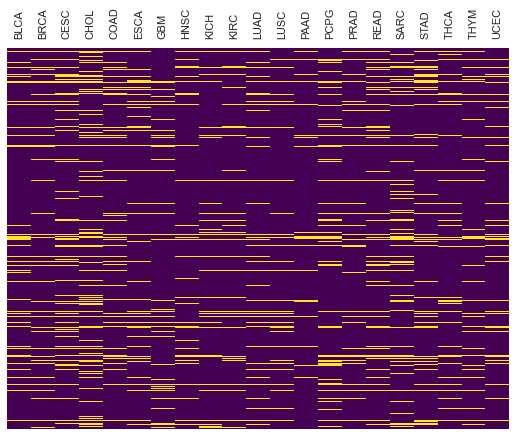

In [56]:
import seaborn
import matplotlib.pyplot as plt

seaborn.set(rc={'figure.figsize': (9,7), 
                'xtick.labeltop': True,
                'xtick.labelbottom': False})

for i in ('consensus_canc', 'consensus_norm'):
    seaborn.heatmap(eval(i).isnull(), 
                    yticklabels=False, 
                    cbar=False, 
                    cmap='viridis')
    plt.savefig(f'../results/misc/{i}_nan_heatmap.png', dpi=300, bbox_inches='tight')

In [78]:
#Compare consensus dataframes element-wise to find differences and stack dataframe
diff = (consensus_canc != consensus_norm).stack()

#Leave only True = indeed different cases
diff = diff[diff].to_frame()

#Use obtained index to select isoform names from consensus datasets
diff['Cancer'] = diff.index.map(consensus_canc.stack())
diff['Norm'] = diff.index.map(consensus_norm.stack())

diff = (diff.drop(0, axis=1)             #Remove 'True' column
        .dropna()                        #Remove NaN values
        .groupby(level=0)                #Group by gene to...
        .filter(lambda x: len(x) >= 5))  #...filter by length of samples >= 5

diff.to_excel('../results/consensus_diff.xlsx')

In [64]:
def extract_form_freq(isoform_list: pandas.Series):
    
    isoform_counts = isoform_list.value_counts(normalize=True)
    return isoform_counts

def consider_gene(gene: str, canc: str, norm: str):
    global samples
    
    form_freq = pandas.DataFrame(index=[canc, norm], columns=samples)
    for s in samples:
        try:
            canc = pandas.read_csv(f'../data/tcga_prevailing/{s}_canc.csv', index_col=0)[gene]
        try:
            norm = pandas.read_csv(f'../data/tcga_prevailing/{s}_norm.csv', index_col=0)[gene]
        except
        temp = pandas.concat(canc, norm)
        form_freq[f'{s}'] = temp.apply(pandas.Series.value_counts, axis=1, normalize=True)
        
    return form_freq

In [ ]:
form_freq('NLRP3', '')

In [ ]:
def consider_gene(gene: str):
    global samples
    canc_all = [pandas.read_csv(f'../data/tcga_prevailing/{s}_canc.csv', index_col=0)[gene] for s in samples]
    norm_all = [pandas.read_csv(f'../data/tcga_prevailing/{s}_norm.csv', index_col=0)[gene] for s in samples]
    isoforms_canc, isoforms_norm = set(), set()
    isoforms_canc = [isoforms_canc | set(i.index) for i in canc_all]
    isoforms_norm = [isoforms_norm | set(i.index) for i in norm_all]
    index_level_1 = ['Canc'] * len(isoforms_canc) + ['Norm'] * len(isoforms_norm)
    index_level_2 = 

In [71]:
CESC_canc_prev = pandas.read_csv(f'../data/tcga_prevailing/CESC_canc.csv', index_col=0)

In [75]:
'NLRP3' in genes_all

True

In [76]:
sc_data = pandas.read_csv(f'../data/tcga_initial/KIDNEY_canc.tsv', sep='\t')

In [77]:
sc_data

,UniProt,canonical,chr,Gene,ucsc,Avg,TCGA-3Z-A93Z-01A-11R-A37O-07,TCGA-6D-AA2E-01A-11R-A37O-07,TCGA-A3-3306-01A-01R-0864-07,TCGA-A3-3307-01A-01R-0864-07,...,TCGA-G6-A5PC-01A-11R-A33J-07,TCGA-G6-A8L6-01A-11R-A37O-07,TCGA-G6-A8L7-01A-11R-A37O-07,TCGA-G6-A8L8-01A-21R-A37O-07,TCGA-GK-A6C7-01A-11R-A33J-07,TCGA-MM-A563-01A-11R-A266-07,TCGA-MM-A564-01A-11R-A266-07,TCGA-MM-A84U-01A-11R-A37O-07,TCGA-MW-A4EC-01A-11R-A266-07,TCGA-T7-A92I-01A-11R-A37O-07
0,A0A5B9,A0A5B9,chr07,TRBC2,uc003wbh,5.858151,6.717287,6.139183,4.646791,6.682648,...,8.404824,7.283078,5.954441,6.145415,6.411692,7.267070,6.693225,6.543726,5.648785,5.294955
1,A0AUZ9,A0AUZ9,chr02,KANSL1L,uc002vds,9.869458,10.043090,9.317853,10.667831,10.736789,...,9.358876,9.760936,7.452617,10.163722,10.167995,9.587088,9.512076,10.047196,9.846372,10.163091
2,A0AUZ9-3,A0AUZ9,chr02,KANSL1L,uc002vdv,4.492186,3.256044,3.051998,4.198361,5.516050,...,4.519976,1.693320,4.607833,5.323903,5.906633,3.200740,4.059156,4.267423,4.128434,6.132859
3,A0AUZ9-4,A0AUZ9,chr02,KANSL1L,uc002vdx,3.734040,2.783121,2.936892,4.477502,4.419802,...,2.369327,3.096110,3.695816,5.727360,4.161436,4.235543,3.294827,3.138536,4.170630,5.123248
4,A0AV02,A0AV02,chr03,SLC12A8,uc003ehv,4.266896,3.561595,5.993131,0.000000,0.000000,...,0.000000,3.725021,3.742168,5.956466,0.000000,5.332174,0.000000,4.643366,2.472514,3.337540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16348,Q9Y6X8,Q9Y6X8,chr08,ZHX2,uc003ypk,10.484030,9.711988,9.977429,11.147350,10.707830,...,9.739521,9.935917,10.405080,10.177030,10.385800,10.258240,11.077300,10.988610,9.992171,9.808294
16349,Q9Y6Y1,Q9Y6Y1,chr01,CAMTA1,uc001aoi,3.049786,1.536103,3.193062,0.000000,2.878078,...,1.188464,0.000000,0.000000,0.000000,4.775830,1.960882,0.000000,0.000000,2.785613,4.930430
16350,Q9Y6Y8,Q9Y6Y8,chr10,SEC23IP,uc001leu,9.578392,8.310626,9.390266,9.864598,9.903900,...,5.556074,6.962933,5.172432,7.813603,10.249460,8.722094,6.941274,8.522002,9.363577,10.746870
16351,Q9Y6Y9,Q9Y6Y9,chr08,LY96,uc003yad,7.106960,6.491983,8.726037,6.509422,6.766930,...,6.312184,6.633691,5.621750,5.019791,5.863036,8.075069,6.505645,8.347560,6.848053,9.551450


In [79]:
tissues = ['bladder', 'esophagus', 'kidney', 'liver', 'lung', 'stomach']

In [81]:
start = timeit.default_timer()
for i, s in enumerate(tissues):
    new = timeit.default_timer()
    
    #Handle 'cancer' dataset
    sc_data = pandas.read_csv(f'../data/tcga_initial/{s}_canc.tsv', sep='\t')
    sc_prev = assign_prevailing_forms(sc_data)
    sc_prev.to_csv(f'../data/tcga_prevailing/{s}_canc.csv', index=True)
    
    #Handle 'norm' dataset
    sn_data = pandas.read_csv(f'../data/tcga_initial/{s}_norm.tsv', sep='\t')
    sn_prev = assign_prevailing_forms(sn_data)
    sn_prev.to_csv(f'../data/tcga_prevailing/{s}_norm.csv', index=True)
    
    elapsed_one = timeit.default_timer() - new
    elapsed_total = timeit.default_timer() - start
    
    msg = f'Done {i+1} out of {len(samples)} samples, '\
          f'last took {elapsed_one:.2f} s, total {elapsed_total:.2f} s'
    
    print(msg, end='\r')